In [34]:
import numpy as np
import matplotlib as mp
from matplotlib import pyplot as plt
import sounddevice as sd
from tqdm.notebook import tqdm_notebook
import time

CLR = {
    1: '#06050D',
    2: '#161233',
    3: '#261E5A',
    4: '#362A81',
    5: '#4636A8'
}


# Шумы

*Белый шум* - стационарный шум, спектральные составляющие которого равномерно распределены по всему диапазону задействованных частот. 
В нем частоты всего звукового диапазона, который человеческий слух может воспринять: от 20 до 20 000 Гц.
Другими словами, белый шум – это «смесь» звуков, воспроизводимых одновременно на всех частотах, которые воспринимает наше ухо. 


*Аддитивный белый гауссовский шум (AWGN)* - базовая модель шума, используемая в теории информации для имитации эффекта многих случайных процессов, происходящих в природе. Модификаторы обозначают специфические характеристики:

**Аддитивный**, потому что он добавляется к любому шуму, который может быть присущ информационной системе.

**Белый шум** относится к идее о том, что он имеет равномерную спектральную плотность мощности во всей полосе частот информационной системы. Это аналогия с белым цветом, который может быть реализован за счет равномерного излучения на всех частотах в видимом спектре.

**Гауссовский**, потому что он имеет нормальное распределение во временной области со средним значением во временной области, равным нулю (гауссовский процесс).


# Белый шум

## Генератор белого шума

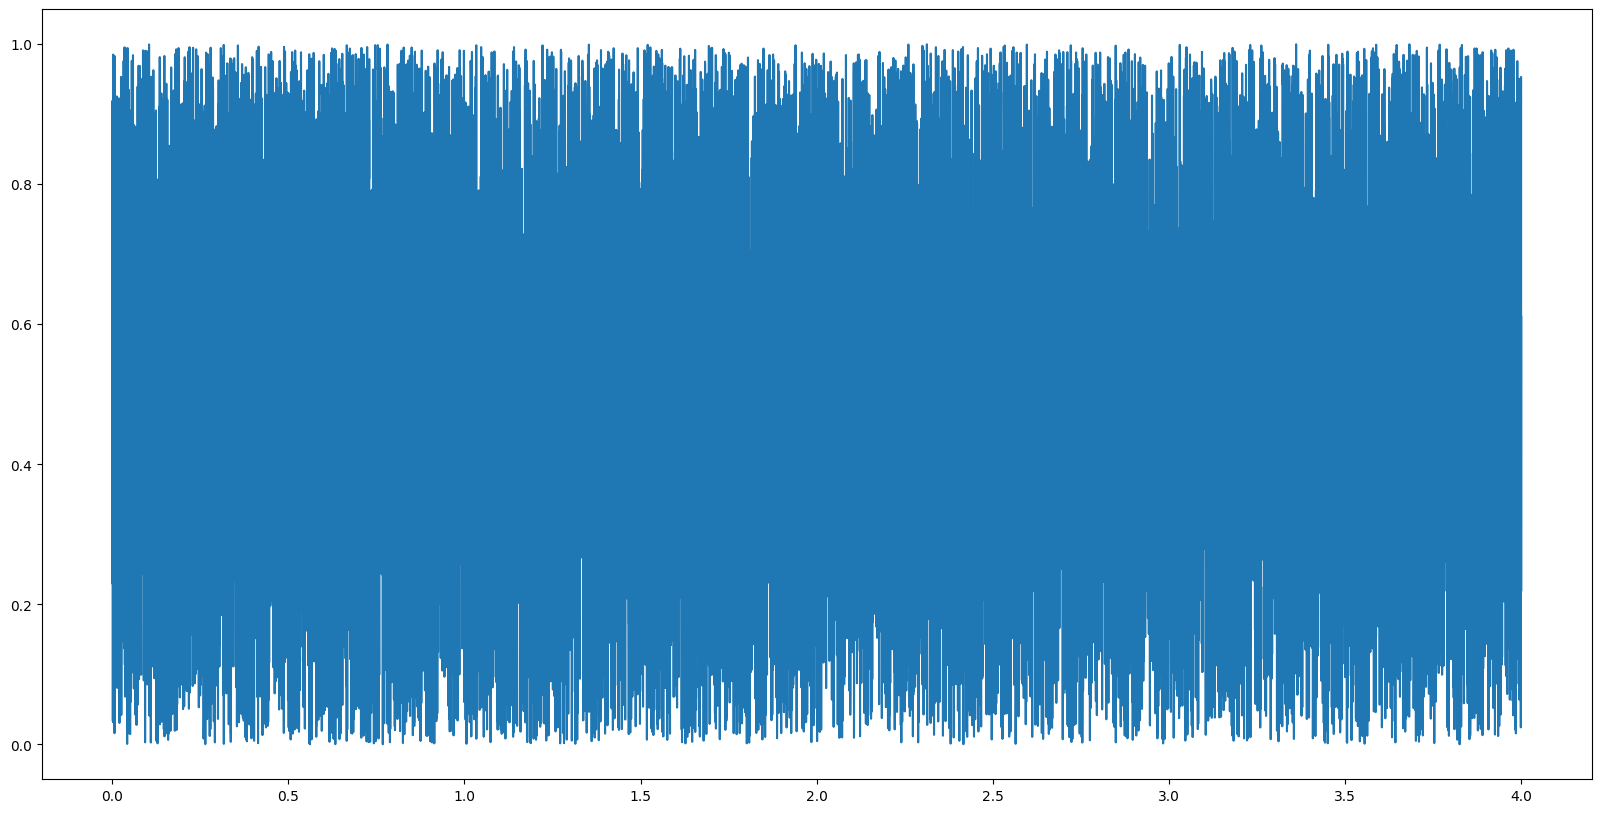

In [35]:
SEC = 4 # Продолжительность шума в секундах
SAMPLE_RATE = 3200  # Частота дискретизации в Гц
LEN_SAMPLE = SEC * SAMPLE_RATE    #  Кол-во генерируемых элементов

generator = np.random.default_rng()
white_noise = [generator.random() for _ in range(LEN_SAMPLE)]
time_axis = np.linspace(0, SEC, LEN_SAMPLE)
plt.figure(figsize=[20, 10])
plt.plot(time_axis, white_noise)


### Проигрывание белого шума

In [4]:
sd.play(white_noise, samplerate=SAMPLE_RATE, blocking=True)

## Генерация Гауссовского белого шума

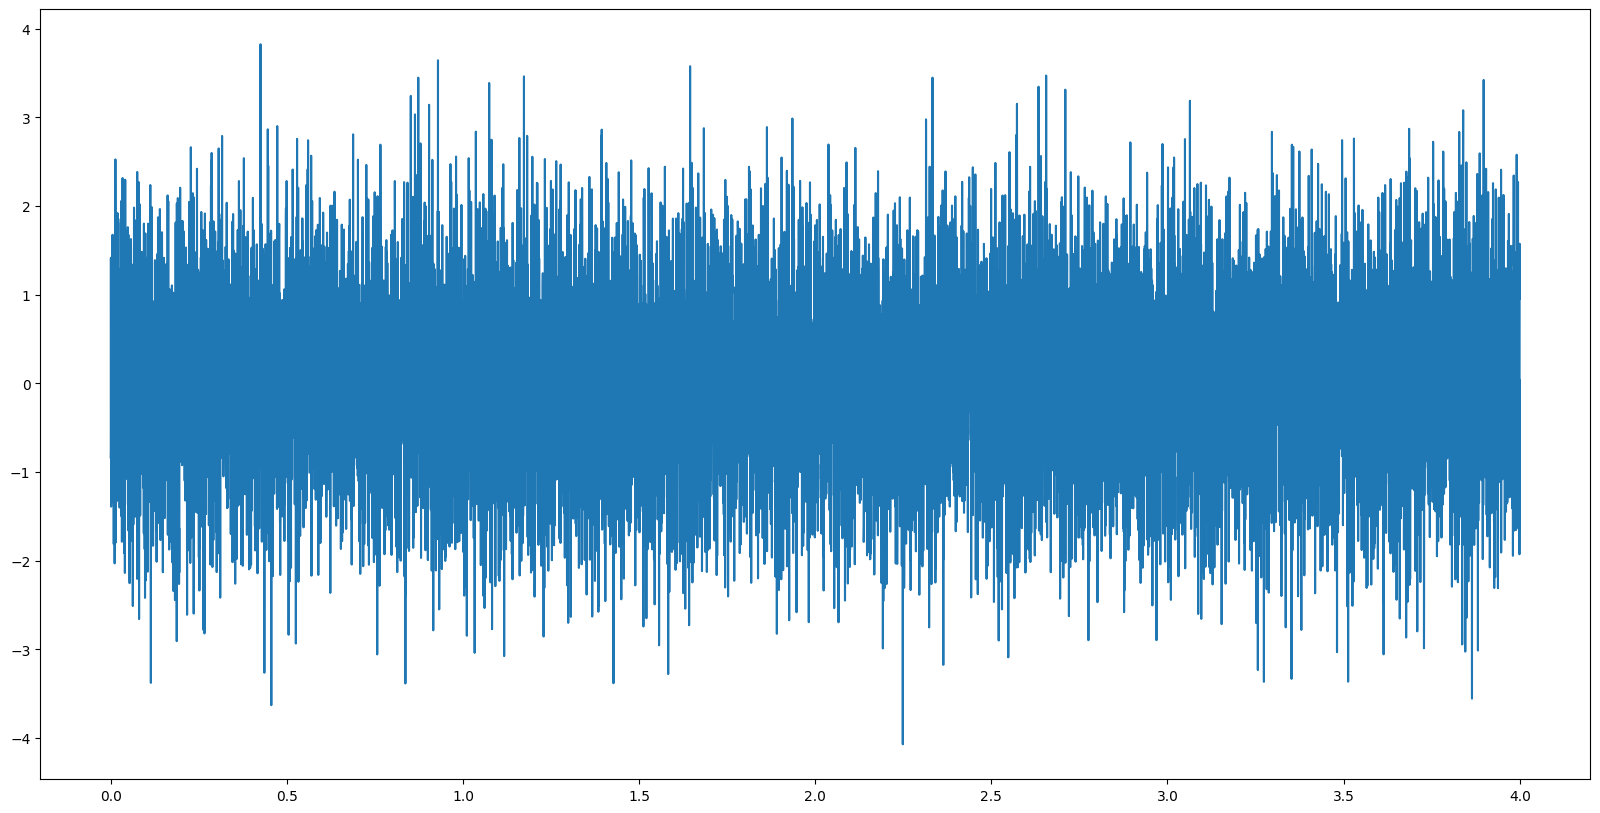

In [5]:
# loc - медиана
# scale - стандартная девиация
white_noise_g = np.random.normal(loc = 0, scale = 1, size = LEN_SAMPLE)
plt.figure(figsize=[20, 10])
plt.plot(time_axis, white_noise_g)

### Проигрывание белого шума

In [6]:
sd.play(white_noise_g, samplerate=SAMPLE_RATE, blocking=True)

## Сравнение распределений двух шумов

C:\Users\danon\AppData\Local\Temp\ipykernel_2932\4113087031.py:15: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([c0, c1],


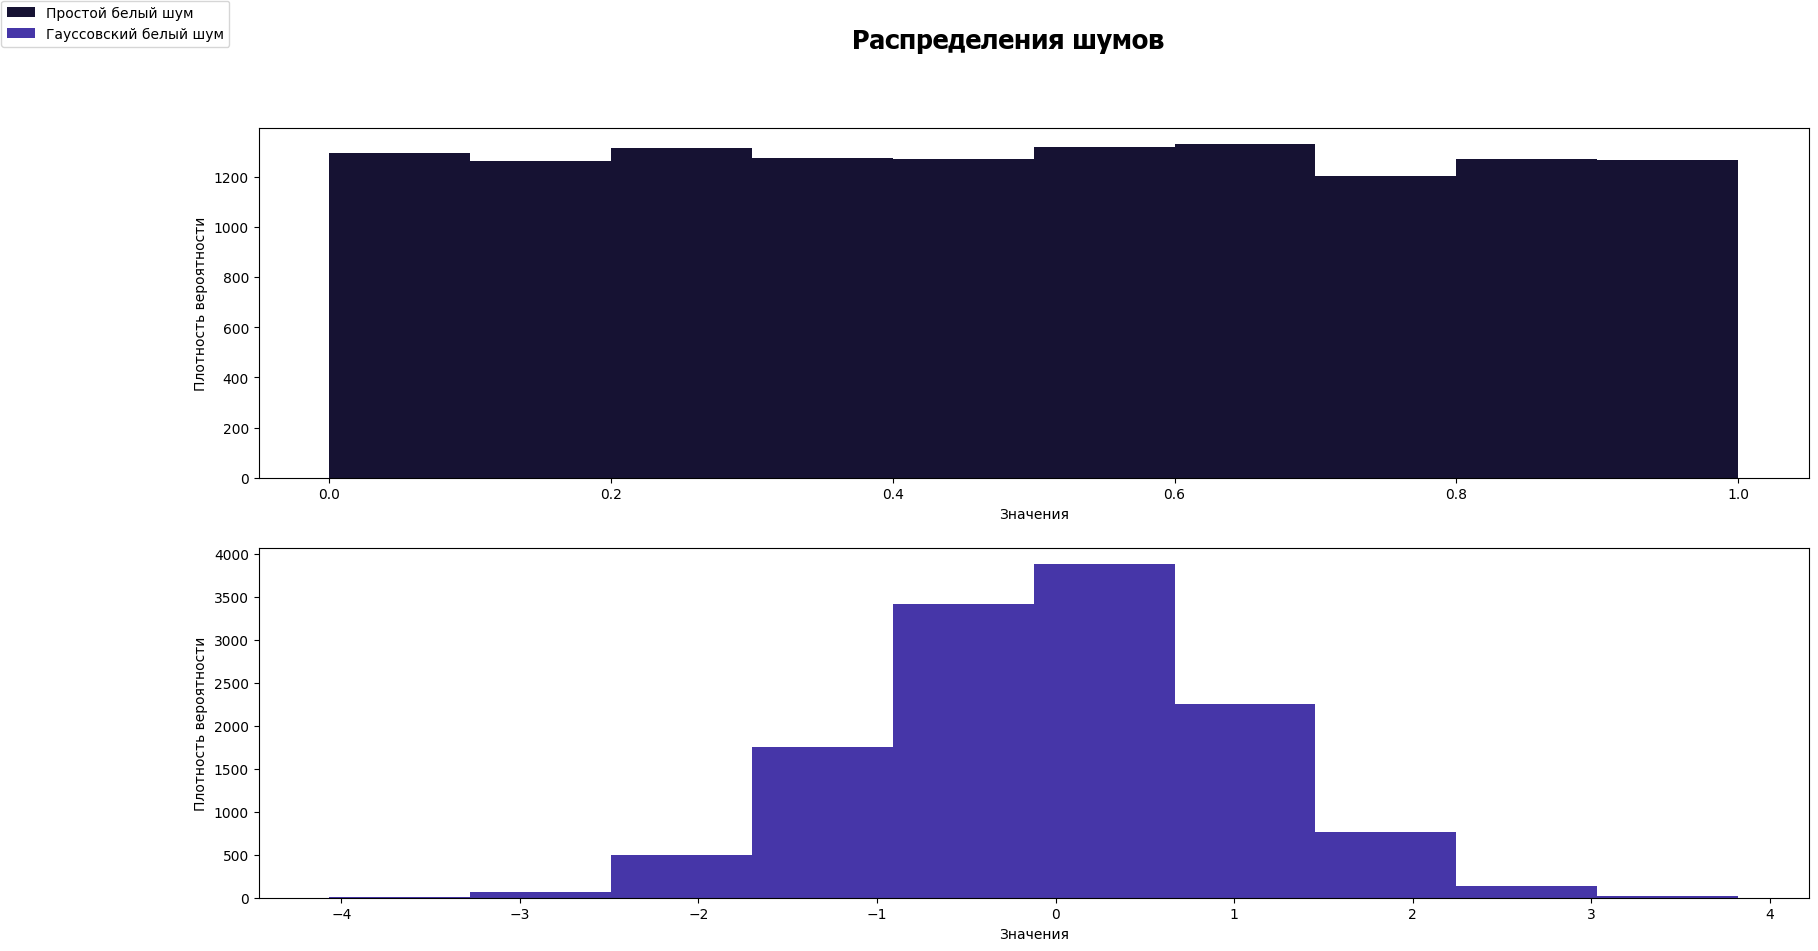

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(20, 10))
fig.suptitle('Распределения шумов', fontsize=19, fontweight='bold', fontfamily='Tahoma')
labels = ["Простой белый шум", "Гауссовский белый шум"]

# определяем, что будем отрисовывать на 1 графике. По x - амплитуды, по y - плотность вероятности
c1 = axs[0].hist(white_noise, color=CLR[2])
axs[0].set_xlabel('Значения')
axs[0].set_ylabel('Плотность вероятности')
# определяем, что будем отрисовывать на 2 графике. По x - амплитуды, по y - плотность вероятности
c0 = axs[1].hist(white_noise_g, color=CLR[5])
axs[1].set_xlabel('Значения')
axs[1].set_ylabel('Плотность вероятности')

# отрисовываем общую легенду
fig.legend([c0, c1],
           labels=labels,
           loc='upper left',
           borderaxespad=0.1)

plt.show()

# Коричневый шум

*Коричневый шум* - больше выделяются низкие частоты (имеют высокие амплитуды). Получается интегрирвание белого шума. 

Для этого нужно:
Создать белый гауссовкий шум с нулевой медианой.
Вычислить кумулятивную сумму полученного белого шума
От кумулятивной суммы отнять медианное значение
Отмасштабировать

На заметку:
Коричневый шум имеет ОГРОМНОЕ количество энергии на очень низких частотах и теоретически бесконечную энергию на частоте 0 Гц. Это, скорее всего, перегрузит любую разумную систему, поэтому вам, вероятно, понадобится коричневый шум с «ограниченной полосой пропускания». Самый простой способ сделать это — использовать фильтр верхних и нижних частот первого порядка вместо интегратора. Например, фильтр верхних частот на частоте 20 Гц и фильтр нижних частот на частоте 40 Гц.

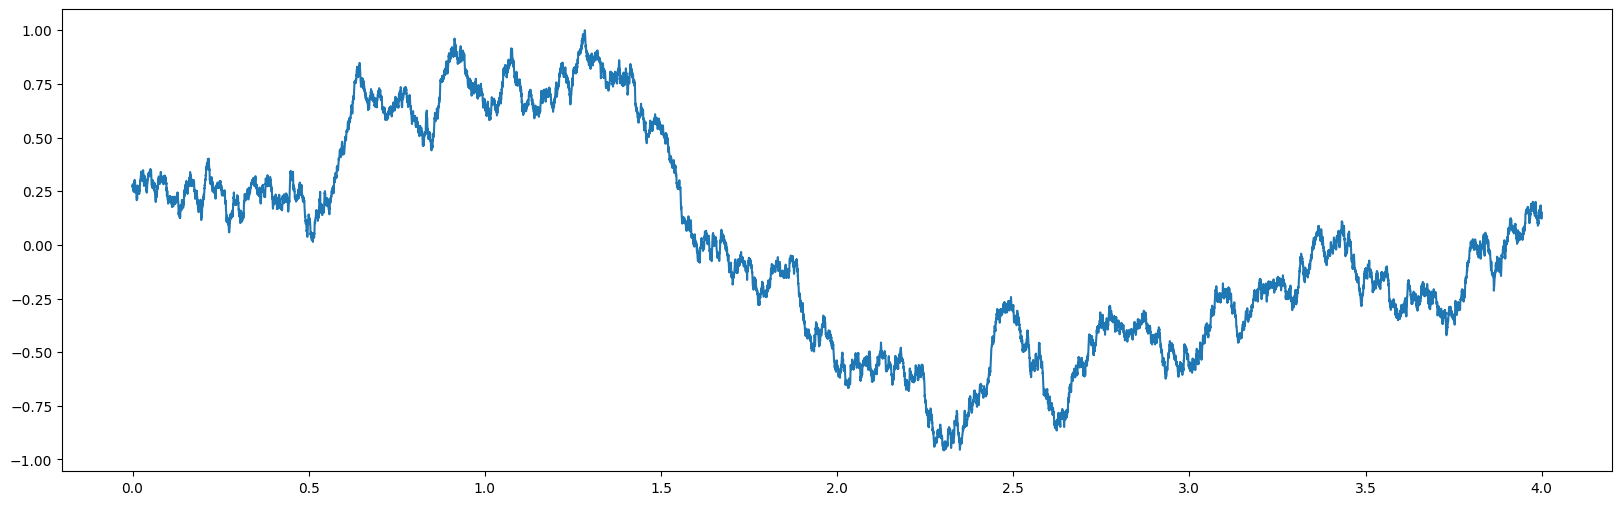

In [8]:
cumsum = np.cumsum(white_noise_g)  # Кумулятивная сумма
brown_noise = cumsum - np.mean(cumsum)  # Обнуляем медианное значение
scale_coeff =  np.max(np.abs(brown_noise))   # Коэффициент для масшабирования, чтобы весь ряд находился между -1 и 1
brown_noise = brown_noise / scale_coeff  # Нормализация к [-1, 1] . Каждый элемент ряда делится на масштабирующий коэффициент

plt.figure(figsize=(20, 6)) 
plt.plot(time_axis, brown_noise)

In [9]:
sd.play(brown_noise, SAMPLE_RATE, blocking=True)

# Розовый шум

*Розовый шум* или фликкер (мерцающий) шум - очень похож на белый. 

Розовый шум может быть сгенерирован путем первой генерации сигнала белого шума, преобразования его Фурье, затем деления амплитуд различных частотных составляющих на квадратный корень из частоты (в одном измерении) или на частоту (в двух измерениях) и т.д. Это эквивалентно пространственной фильтрации (свертке) сигнала белого шума с помощью фильтра от белого к розовому. Для сигнала длины N в одном измерении 

![Alt text](image-1.png)

In [21]:
# применение фильтра для генерации розового шума

N = len(white_noise_g)
N2 = N//2

pink_noise_f = []
print(N)
for el in white_noise_g:
    s = 0
    for k in range(1,N2):
        s += 1/np.sqrt(k) * np.cos(2*np.pi*k*(el-1)/N)
    s *=2
    s = s + 1 + np.cos(np.pi*(el-1))/np.sqrt(N2)
    pink_noise_f.append(s/N)

12800


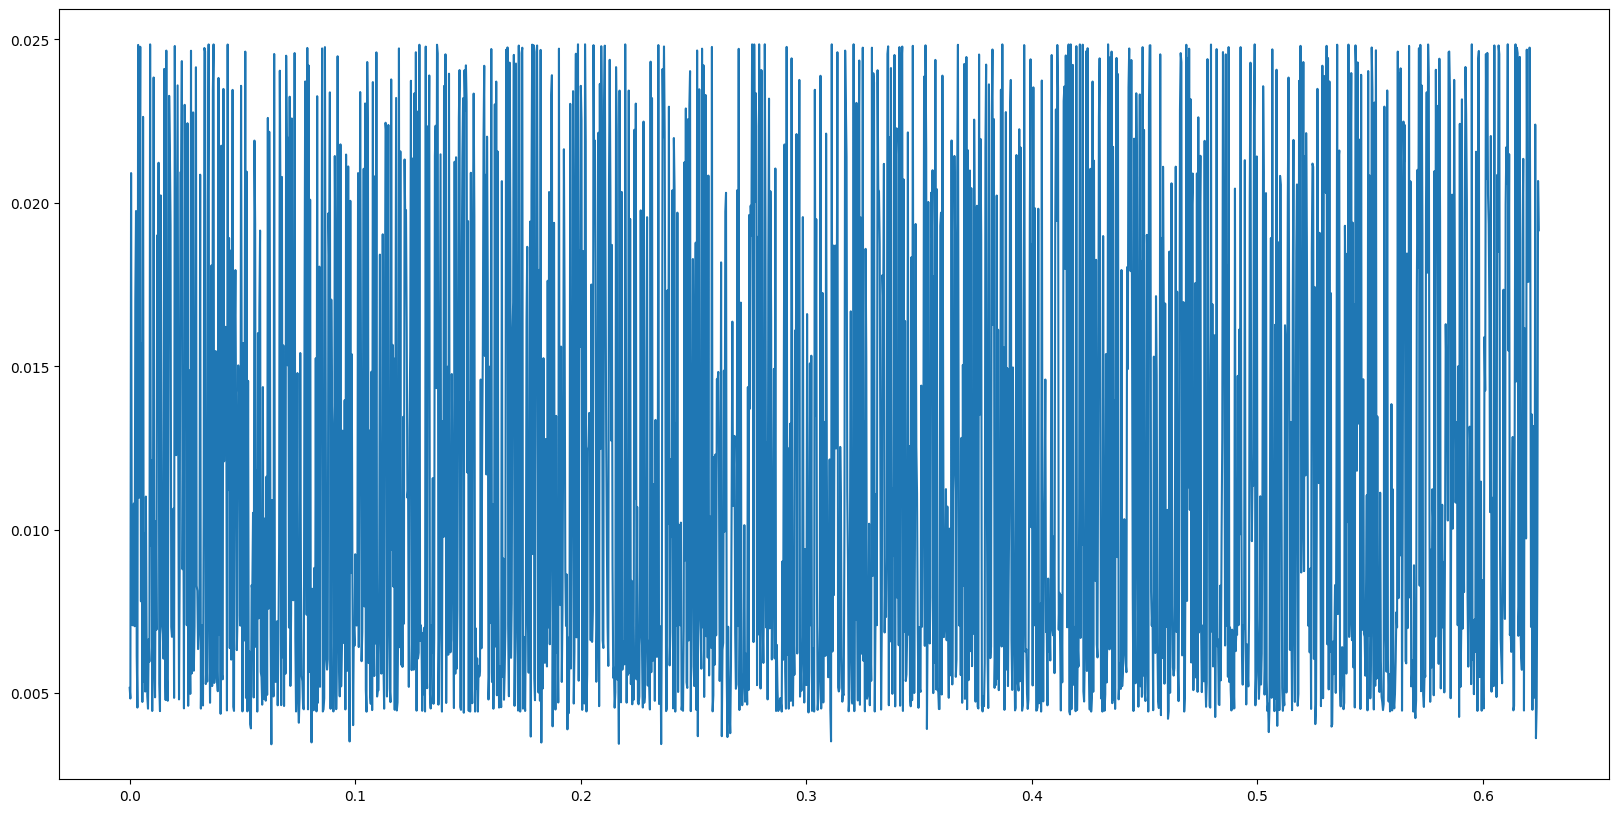

In [23]:
plt.figure(figsize=(20, 10))
plt.plot(time_axis[:2000], pink_noise_f[:2000])

In [24]:
sd.play(pink_noise_f, SAMPLE_RATE, blocking=True)

## Практика
### Генерация розового шума

In [29]:
# frr = np.fft.rfft(white_noise_g)    # Используем преобразование Фурье для белого шума (простого)
# freq = np.fft.rfftfreq(len(frr), 1.0 / len(frr)) + 1
# flicker_spectrum = 1 / np.sqrt(freq)
# pink_noise = np.fft.irfft(frr * flicker_spectrum)
fft = np.fft.rfft(white_noise_g)
freq = np.fft.rfftfreq(len(white_noise_g), 1.0 / len(white_noise_g)) + 1
flicker_spectrum = 1 / np.sqrt(freq)

pink_noise = np.fft.irfft(fft * flicker_spectrum)

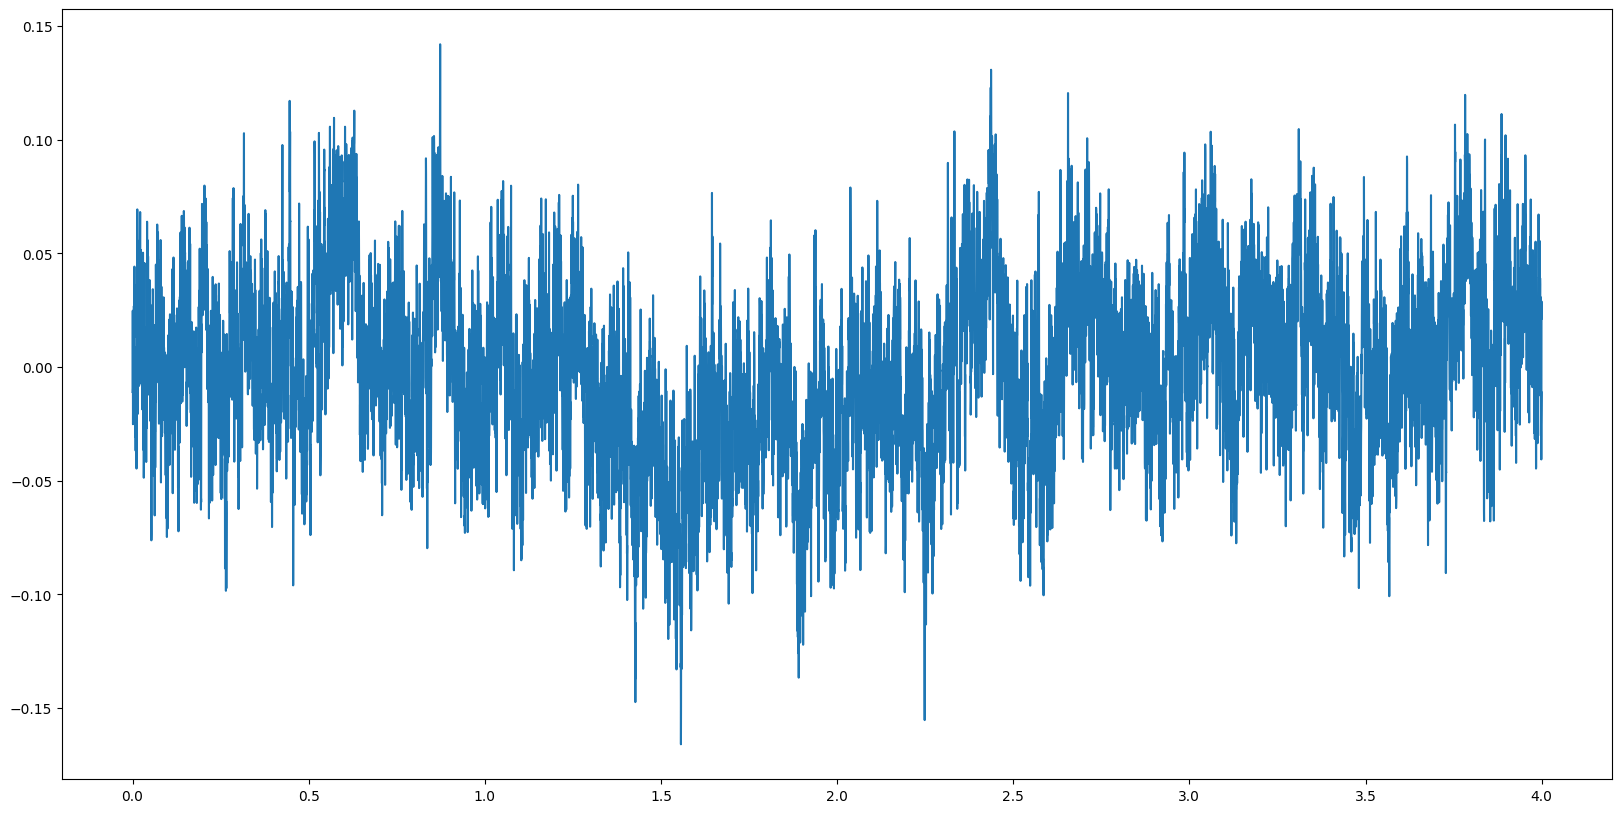

In [30]:
axis_time = np.linspace(0, SEC, len(pink_noise))
plt.figure(figsize=(20, 10))
plt.plot(axis_time, pink_noise)

In [32]:
sd.play(pink_noise, SAMPLE_RATE, blocking=True)

# Черный шум

In [41]:
# количество элементов в записи сигнала
freq1 = 20000
freq2 = 25000
# Частоты, на которых будем генерировать
num_frequencies = 100  # Количество случайных частот
frequencies = np.linspace(freq1, freq2, num_frequencies) # лист с частотами

black_noise = np.zeros(LEN_SAMPLE)   # подготовили лист для записи сигнала
time_axis = np.arange(LEN_SAMPLE) / SAMPLE_RATE   # задали временную ось

amplitudes = np.random.normal(0, 1, num_frequencies)  # опять сгенерировали белый гауссовский шум

black_noise = np.zeros(LEN_SAMPLE)
time_axis = np.arange(LEN_SAMPLE) / SAMPLE_RATE

for i in range(num_frequencies):
    # надо описать, откуда вы взяли эту формулу
    black_noise += amplitudes[i] * np.sin(2 * np.pi * frequencies[i] * time_axis)

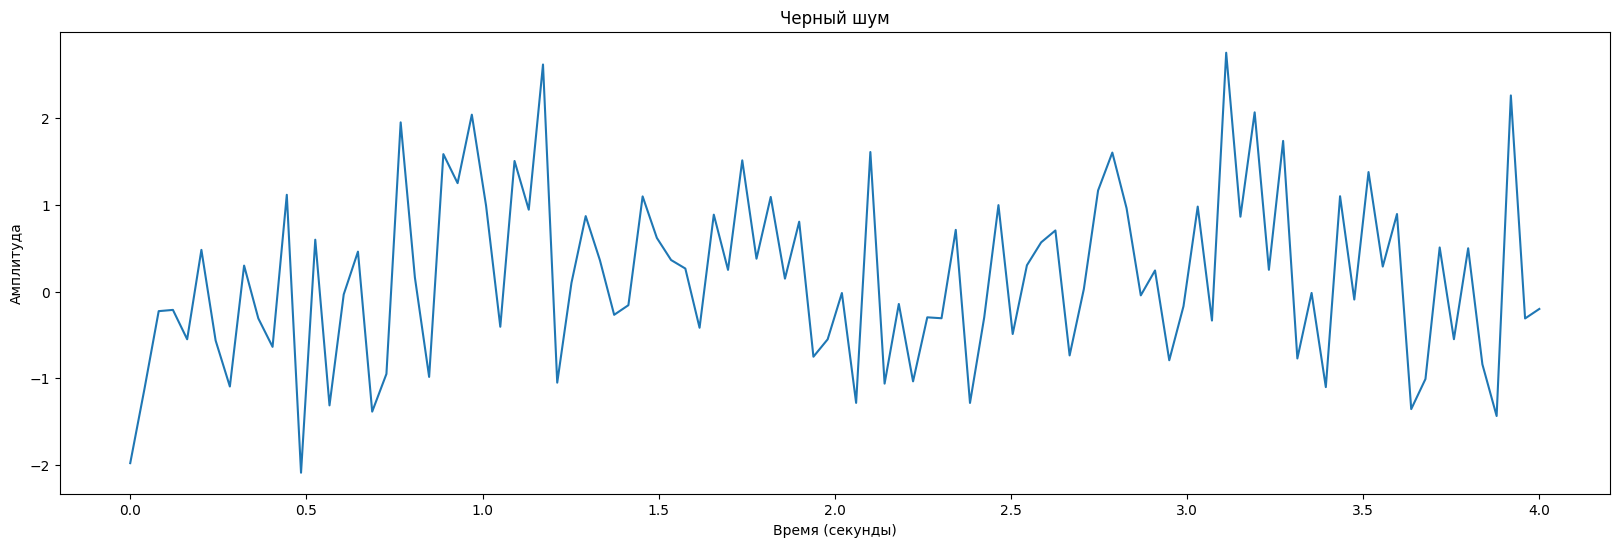

In [42]:
time_axis = np.linspace(0, SEC, len(amplitudes))
plt.figure(figsize=(20, 6))
plt.plot(time_axis, amplitudes)
plt.title('Черный шум')
plt.xlabel('Время (секунды)')
plt.ylabel('Амплитуда')
plt.show()

In [43]:
sd.play(black_noise, SAMPLE_RATE, blocking=True)

Черный шум - как излучение абсолютно черного тела

Cпектральная плотность мощности излучения известна (непрерывную функцию частоты - f и температуры - T):

![Alt text](image.png)

kB - постоянная Больцмана
h  - Постоянная Планка
c  - скорость света

Поскольку выходная величина должна быть выражена в децибелах, чтобы иметь смысл для звука, мы просто используем логарифмическую шкалу и добавляем смещение (усиление), чтобы нормализовать пик до 0. Уравнение кривой эквалайзера равно:

![Alt text](image-2.png)

Еквалайзер применяем к белому шуму

In [44]:
import scipy

kb =  scipy.constants.k
h = scipy.constants.physical_constants['Planck constant'][0]
c = scipy.constants.c

print(kb)
print(h)
print(c)

T = 17*1/np.power(10, 9)  #Температура 17 нанокельвинов
G = 10

coef1 = 2*h/(c*c*T*T*T)
coef2 = h/(kb*T)

freq1 = 1000
# Частоты, на которых будем генерировать

black_noise = np.zeros(LEN_SAMPLE)   # подготовили лист для записи сигнала
time_axis = np.arange(LEN_SAMPLE) / SAMPLE_RATE   # задали временную ось



black_noise = np.zeros(LEN_SAMPLE)
time_axis = np.arange(LEN_SAMPLE) / SAMPLE_RATE
eq = 10 * np.log(coef1*np.power(freq1,3)/(np.exp(coef2*freq1)-1)) + 10 # эквалайзер

white_noise_g = np.random.normal(loc = 0, scale = 1, size = LEN_SAMPLE) # опять белый шум

black_noise = white_noise_g + eq # применяем преобразование к белому шуму

black_noise /= np.max(np.abs(black_noise))  # Нормализация амплитуды к [-1, 1]

1.380649e-23
6.62607015e-34
299792458.0


In [49]:
# так звучит черное тело
sd.play(black_noise, freq1, blocking=True)

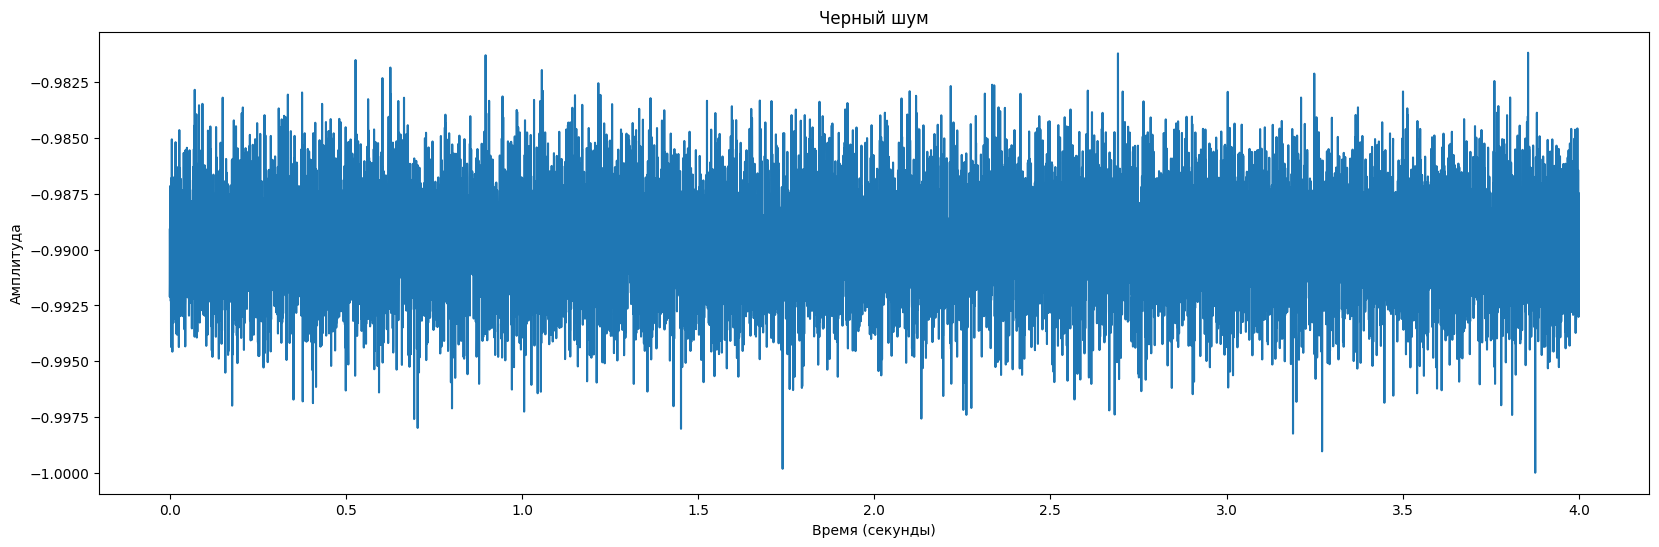

In [48]:
# Визуализация
time_axis = np.linspace(0, SEC, len(black_noise))
plt.figure(figsize=(20, 6))
plt.plot(time_axis, black_noise)
plt.title('Черный шум')
plt.xlabel('Время (секунды)')
plt.ylabel('Амплитуда')
plt.show()

# Генерация временных рядов

In [54]:
SEC = 8                             # Продолжительность в секундах
SAMPLE_RATE = 11025                 # Частота дискретизации звука
COUNT_POINT = SEC * SAMPLE_RATE     # Количество точек в серии

TIME_AXIS = np.linspace(0, SEC, COUNT_POINT)    # Временная ось

In [55]:
signal = list(map(lambda x: np.sin(x)*np.cos(x*x), TIME_AXIS))  # чистый сигнал

In [87]:
white_noise = np.random.normal(0,1,size=COUNT_POINT)  # Генерим белый шум
cumsum = np.cumsum(white_noise)                       # Кумулятивная сумма
brown_noise = cumsum - np.mean(cumsum)                # Обнуляем медианное значение
scale_coeff =  np.max(np.abs(brown_noise))            # Коэффициент для масшабирования, чтобы весь ряд находился между -1 и 1
brown_noise = brown_noise / scale_coeff               # Нормализация к [-1, 1] . Каждый элемент ряда делится на масштабирующий коэффициент
white_noise = brown_noise

In [88]:
noise_signal = signal * white_noise

C:\Users\danon\AppData\Local\Temp\ipykernel_2932\4172729119.py:21: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([c0, c1, c2],


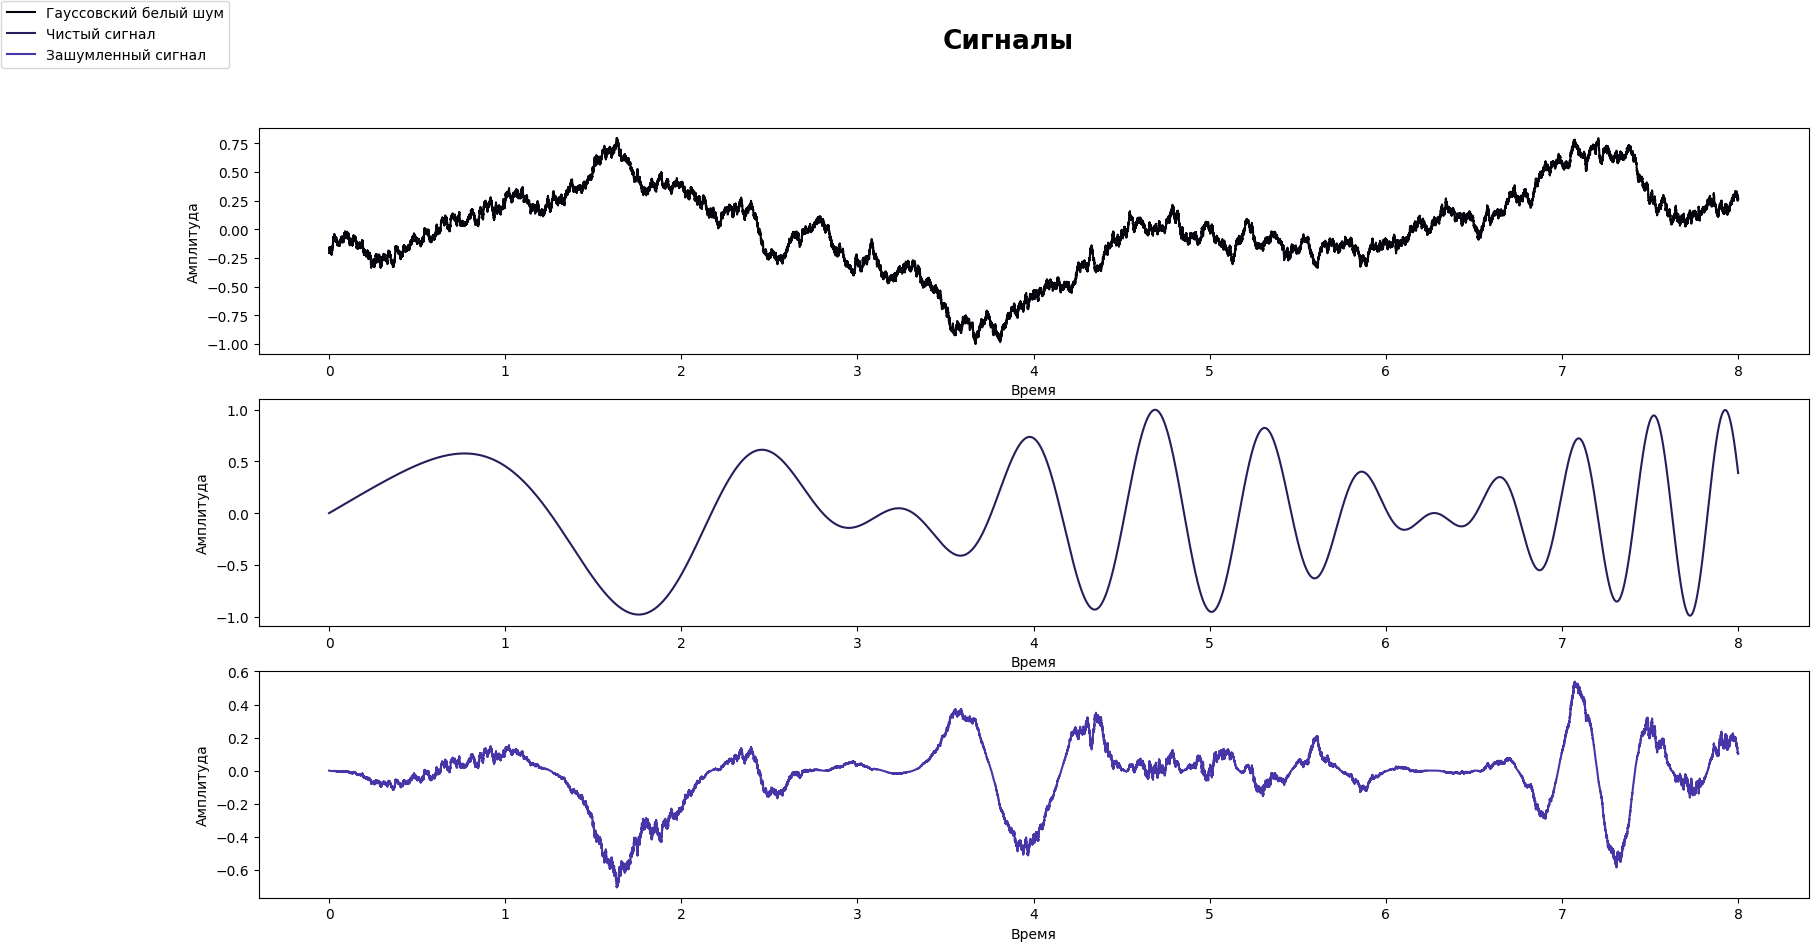

In [89]:
fig, axs = plt.subplots(3, 1, figsize=(20, 10))
fig.suptitle('Сигналы', fontsize=19, fontweight='bold')
labels = ["Гауссовский белый шум", "Чистый сигнал", "Зашумленный сигнал"]

# определяем, что будем отрисовывать на 1 графике. По x - время, по y - амплитуды
c0 = axs[0].plot(TIME_AXIS, white_noise, color=CLR[1])
axs[0].set_xlabel('Время')
axs[0].set_ylabel('Амплитуда')

# определяем, что будем отрисовывать. По x - время, по y - амплитуды
c1 = axs[1].plot(TIME_AXIS, signal, color=CLR[3])
axs[1].set_xlabel('Время')
axs[1].set_ylabel('Амплитуда')

# определяем, что будем отрисовывать. По x - время, по y - амплитуды
c2 = axs[2].plot(TIME_AXIS, noise_signal, color=CLR[5])
axs[2].set_xlabel('Время')
axs[2].set_ylabel('Амплитуда')

# отрисовываем общую легенду
fig.legend([c0, c1, c2],
           labels=labels,
           loc='upper left',
           borderaxespad=0.1)

In [84]:
sd.play(white_noise, SAMPLE_RATE, blocking=True)    # Шум

In [75]:
sd.play(signal, SAMPLE_RATE, blocking=True)        # Сигнал

In [90]:
sd.play(noise_signal, SAMPLE_RATE, blocking=True)  # Зашумленный сигнал